# Case Study: How Does a Bike-Share Navigate Speedy Success?

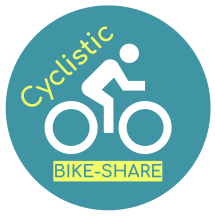

### Scenario

In 2016, Cyclistic launched a successful bike-share offering. Since then, the program has grown to a fleet of 5,824 bicycles that
are geotracked and locked into a network of 692 stations across Chicago. The bikes can be unlocked from one station and
returned to any other station in the system anytime.
Until now, Cyclistic’s marketing strategy relied on building general awareness and appealing to broad consumer segments.
One approach that helped make these things possible was the flexibility of its pricing plans: single-ride passes, full-day passes,
and annual memberships. Customers who purchase single-ride or full-day passes are referred to as casual riders. Customers
who purchase annual memberships are Cyclistic members.
Cyclistic’s finance analysts have concluded that annual members are much more profitable than casual riders. Although the
pricing flexibility helps Cyclistic attract more customers, Moreno believes that maximizing the number of annual members will
be key to future growth. Rather than creating a marketing campaign that targets all-new customers, Moreno believes there is a
very good chance to convert casual riders into members. She notes that casual riders are already aware of the Cyclistic
program and have chosen Cyclistic for their mobility needs.
Moreno has set a clear goal: Design marketing strategies aimed at converting casual riders into annual members. In order to
do that, however, the marketing analyst team needs to better understand how annual members and casual riders differ, why
casual riders would buy a membership, and how digital media could affect their marketing tactics. Moreno and her team are
interested in analyzing the Cyclistic historical bike trip data to identify trends.



### Guiding questions

1. In what ways do annual members and casual riders differ in bike usage?

2. In what scenarios might casual riders want to buy an annual membership?

3. How can the firm use digital media to influence casual riders to become annual members? 



### Key business tasks

Compare and analyze bike usage patterns of casual riders and annual members and recommend strategies to influence the former to buy an annual membership through digital media.


### Rationale 

1. Annual subscribers yield more profit
2. Casual users are already aware and have experience with app


* The data is located on AWS cloud services, accessible using the link: https://divvy-tripdata.s3.amazonaws.com/index.html

* The data is organized as month-wise, zipped csv files. Monthly data is shown as last updated mostly within first week of next month, barring 2-3 exceptions.  \




* **ROCCC Test**

Reliability: The data is not reliable with multiple NaN values in station id's and names. Also, data for some month has been last updated 2 months afterwards.

Originality: The data is not original but secondary, as deployed in AWS.

Comprehensive: The data is not comprehensive, as there is no information about users, or their payment plans. Around 14% rides have station ids and names missing.

Current: The data is not current. The last date in data is 2 months before the date of analysis.

Cited: The data is found on AWS but no independent citations are found.

Hence, data credibility is low. The conclusions of analysis should be considered suggestive but not rigorous. A rigorous analysis can be performed only with a more reliable dataset.


* **Addressing licensing, privacy, security, and accessibility**

At this stage, this is assumed as an open, public-domain data with human identifiers removed and anonymised. No further steps have been taken to customise privacy, security, and accessibility. The data is stored on local hard drive with a back-up copy created.

* **Verifying data integrity**

The data validation was performed on each column. Ride IDs are found to be unique. All values of bike and member types fall under the pre-designated categories. The data type in each column is consistent.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bikeshare/bikeshare.csv


In [2]:
# Importing libraries

import re, random, time, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, calendar
import datetime as dt
from datetime import datetime, timedelta

plt.style.use('ggplot')
sns.set()
sns.set_style('darkgrid')
sns.set_palette('Set2')
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Creating a palette of random colors

hexadecimal_alphabets = '0123456789ABCDEF'
my_colors = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(100)]

In [4]:
# Parsing multiple CSVs in local folder

df = pd.read_csv('../input/bikeshare/bikeshare.csv')
df_copy = df.copy()
df.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0,600CFD130D0FD2A4,electric_bike,2022-06-30 17:27:53,2022-06-30 17:35:15,NaN,NaN,NaN,NaN,41.89,-87.62,41.91,-87.62,casual
1,1,F5E6B5C1682C6464,electric_bike,2022-06-30 18:39:52,2022-06-30 18:47:28,NaN,NaN,NaN,NaN,41.91,-87.62,41.93,-87.63,casual
2,2,B6EB6D27BAD771D2,electric_bike,2022-06-30 11:49:25,2022-06-30 12:02:54,NaN,NaN,NaN,NaN,41.91,-87.65,41.89,-87.61,casual
3,3,C9C320375DE1D5C6,electric_bike,2022-06-30 11:15:25,2022-06-30 11:19:43,NaN,NaN,NaN,NaN,41.80,-87.66,41.80,-87.65,casual
4,4,56C055851023BE98,electric_bike,2022-06-29 23:36:50,2022-06-29 23:45:17,NaN,NaN,NaN,NaN,41.91,-87.63,41.93,-87.64,casual


In [5]:
# Calculating Haversine distance from latitude and longitude

def haversine(lat1, lon1, lat2, lon2):
    
    R = 6371  
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    res = R * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    
    return np.round(res, 2)

### Data Cleaning Documentation

1. 12 monthly CSVs from June 22 to May 23 are merged row-wise. 

2. The start and end times of trips are converted to datetime columns.

3. Month, day and hour information is extracted from each trip's starting time and appended as an additional columns. The month, day, and hour of the trip is taken from the trip starting times (and not ending times).

4. A calculated field is inserted for trip duration, by subtracting the end and start times for each trip.

5. A calculated field is inserted for trip distance, by calculating Haversine distances using the longitude and latitude of start and end stations. 

6. A calculated field is inserted for route by concatenating the ids of start and end stations, separated by a '-'.

7. Two columns are renamed to 'bike_type' and 'member_type'. 

8. A repeating suffix '_bike' is removed from all values in the column 'bike_type'.

9. All rows with NaN values are completely dropped. This leads to a loss of ~15.4% of total data.

10. All trips with duration less than or equal to 0.1 minutes are dropped. These include trips with zero and negative durations, which could be erroneous.

11. All trips with distances less than or equal to 0 are dropped, as these could be erroneous.

12. Data is finally sorted in ascending order of trip start times.


In [6]:
# Data Cleaning and Pre-Processing Steps

df[['started_at','ended_at']] = df[['started_at','ended_at']].apply(pd.to_datetime)
df.insert(4, 'month_year', df['started_at'].dt.to_period('M'))
df.insert(5, 'day_no', df['started_at'].dt.dayofweek)
df.insert(6, 'day_name', df['started_at'].dt.day_name())
df.insert(7, 'hour', df['started_at'].apply(lambda x: x.hour))
df.insert(8, 'duration', (df['ended_at'] - df['started_at']).dt.total_seconds()/60)
df.insert(13, 'route', df['start_station_id'] + '-' + df['end_station_id'])
df.insert(18, 'distance', df.apply(lambda row: haversine(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']), axis=1))
df.rename(columns={'rideable_type': 'bike_type', 'member_casual': 'member_type'}, inplace=True)
df['bike_type'] = df['bike_type'].apply(lambda x: x[:-5])

In [7]:
df.head()

,Unnamed: 0,ride_id,bike_type,started_at,month_year,day_no,day_name,hour,duration,ended_at,...,start_station_id,end_station_name,route,end_station_id,start_lat,start_lng,end_lat,distance,end_lng,member_type
0,0,600CFD130D0FD2A4,electric,2022-06-30 17:27:53,2022-06,3,Thursday,17,7.366667,2022-06-30 17:35:15,...,NaN,NaN,NaN,NaN,41.89,-87.62,41.91,2.22,-87.62,casual
1,1,F5E6B5C1682C6464,electric,2022-06-30 18:39:52,2022-06,3,Thursday,18,7.600000,2022-06-30 18:47:28,...,NaN,NaN,NaN,NaN,41.91,-87.62,41.93,2.37,-87.63,casual
2,2,B6EB6D27BAD771D2,electric,2022-06-30 11:49:25,2022-06,3,Thursday,11,13.483333,2022-06-30 12:02:54,...,NaN,NaN,NaN,NaN,41.91,-87.65,41.89,3.99,-87.61,casual
3,3,C9C320375DE1D5C6,electric,2022-06-30 11:15:25,2022-06,3,Thursday,11,4.300000,2022-06-30 11:19:43,...,NaN,NaN,NaN,NaN,41.80,-87.66,41.80,0.83,-87.65,casual
4,4,56C055851023BE98,electric,2022-06-29 23:36:50,2022-06,2,Wednesday,23,8.450000,2022-06-29 23:45:17,...,NaN,NaN,NaN,NaN,41.91,-87.63,41.93,2.37,-87.64,casual


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5829030 entries, 0 to 5829029
Data columns (total 21 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Unnamed: 0          int64         
 1   ride_id             object        
 2   bike_type           object        
 3   started_at          datetime64[ns]
 4   month_year          period[M]     
 5   day_no              int64         
 6   day_name            object        
 7   hour                int64         
 8   duration            float64       
 9   ended_at            datetime64[ns]
 10  start_station_name  object        
 11  start_station_id    object        
 12  end_station_name    object        
 13  route               object        
 14  end_station_id      object        
 15  start_lat           float64       
 16  start_lng           float64       
 17  end_lat             float64       
 18  distance            float64       
 19  end_lng             float64       
 20  me

In [9]:
(df.isnull().sum()*100)/len(df)

Unnamed: 0             0.000000
ride_id                0.000000
bike_type              0.000000
started_at             0.000000
month_year             0.000000
day_no                 0.000000
day_name               0.000000
hour                   0.000000
duration               0.000000
ended_at               0.000000
start_station_name    14.317048
start_station_id      14.319312
end_station_name      15.298549
route                 22.891442
end_station_id        15.300968
start_lat              0.000000
start_lng              0.000000
end_lat                0.102264
distance               0.102264
end_lng                0.102264
member_type            0.000000
dtype: float64

In [10]:
# Internal validation for nulls, uniques, and duplicates

def validate(df): 

    df_check = pd.DataFrame(index=df.columns)

    for col in df.columns:

        df_check.loc[col, 'Nulls'] = df[col].isnull().sum()
        df_check.loc[col, 'Uniques'] = df[col].nunique()
        df_check.loc[col, 'Duplicates'] = df[col].duplicated().sum()

    df_check['Uniques+Duplicates'] = df_check['Uniques'] + df_check['Duplicates']  
    df_check['Non-Nulls'] = len(df) - df_check['Nulls']
    
    return df_check

In [11]:
# Dropping null rows and filtering 

df.dropna(inplace=True)
df = df[(df['duration'] > 0.1) & (df['distance'] > 0)]
df.sort_values(by='started_at')
df.head()

,Unnamed: 0,ride_id,bike_type,started_at,month_year,day_no,day_name,hour,duration,ended_at,...,start_station_id,end_station_name,route,end_station_id,start_lat,start_lng,end_lat,distance,end_lng,member_type
214,214,76DAD9FC95774B53,electric,2022-06-26 23:59:44,2022-06,6,Sunday,23,25.700000,2022-06-27 00:25:26,...,20222,Burnham Greenway & 105th St,20222-20222,20222,41.704628,-87.528414,41.704575,0.02,-87.528232,casual
216,216,47DE68ACCA138C13,electric,2022-06-27 11:40:53,2022-06,0,Monday,11,9.383333,2022-06-27 11:50:16,...,637,California Ave & Division St,637-13256,13256,41.895611,-87.672098,41.903029,2.26,-87.697474,casual
396,396,32C67769462EDF7B,classic,2022-06-20 16:24:51,2022-06,0,Monday,16,8.800000,2022-06-20 16:33:39,...,13256,California Ave & Milwaukee Ave,13256-13084,13084,41.903029,-87.697474,41.922695,2.19,-87.697153,casual
408,408,ED5BCFCCF7BC19E0,electric,2022-06-20 17:12:43,2022-06,0,Monday,17,70.133333,2022-06-20 18:22:51,...,TA1306000002,Morgan Ave & 14th Pl,TA1306000002-TA1306000002,TA1306000002,41.862423,-87.651162,41.862378,0.01,-87.651062,casual
747,747,69723D14EA8B4131,electric,2022-06-11 19:49:40,2022-06,5,Saturday,19,15.983333,2022-06-11 20:05:39,...,13084,California Ave & Division St,13084-13256,13256,41.922615,-87.697146,41.903029,2.18,-87.697474,casual


In [13]:
validate(df)

,Nulls,Uniques,Duplicates,Uniques+Duplicates,Non-Nulls
Unnamed: 0,0.0,4271316.0,0.0,4271316.0,4271316.0
ride_id,0.0,4271316.0,0.0,4271316.0,4271316.0
bike_type,0.0,3.0,4271313.0,4271316.0,4271316.0
started_at,0.0,3737838.0,533478.0,4271316.0,4271316.0
month_year,0.0,12.0,4271304.0,4271316.0,4271316.0
day_no,0.0,7.0,4271309.0,4271316.0,4271316.0
day_name,0.0,7.0,4271309.0,4271316.0,4271316.0
hour,0.0,24.0,4271292.0,4271316.0,4271316.0
duration,0.0,17793.0,4253523.0,4271316.0,4271316.0
ended_at,0.0,3750131.0,521185.0,4271316.0,4271316.0


Text(0.5, 1.0, 'Percentage of Rides by Bike Types\n')

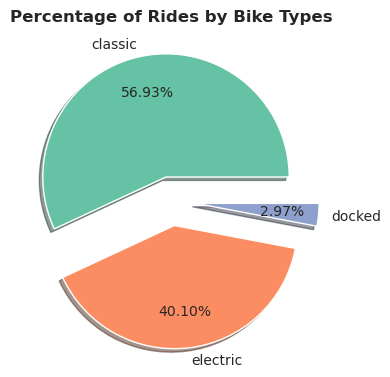

In [14]:
# Getting frequencies for bike types

bike_count = df['bike_type'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(df['bike_type'].value_counts(), labels=bike_count.index, autopct='%1.2f%%', pctdistance=0.7, explode=0.2*np.ones(3), shadow=True, textprops={'fontsize': 10})
plt.title('Percentage of Rides by Bike Types\n', fontweight='bold', fontsize=12)

Classic bikes are used more than electric. Docked bikes are used least.

Text(0.5, 1.0, 'Percentage of Rides by Member Types\n')

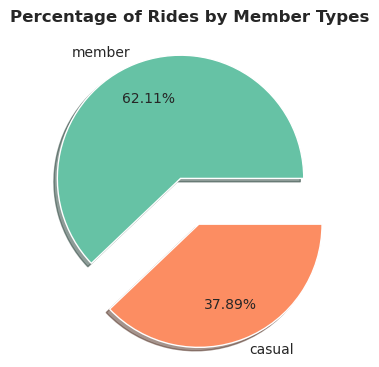

In [15]:
# Getting frequencies for member types

member_count = df['member_type'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(df['member_type'].value_counts(), labels=member_count.index, autopct='%1.2f%%', pctdistance=0.7, explode=0.2*np.ones(2), shadow=True, textprops={'fontsize': 10})
plt.title('Percentage of Rides by Member Types\n', fontweight='bold', fontsize=12)

More rides (62%) are by members.

Text(0, 0.5, 'Ride Counts')

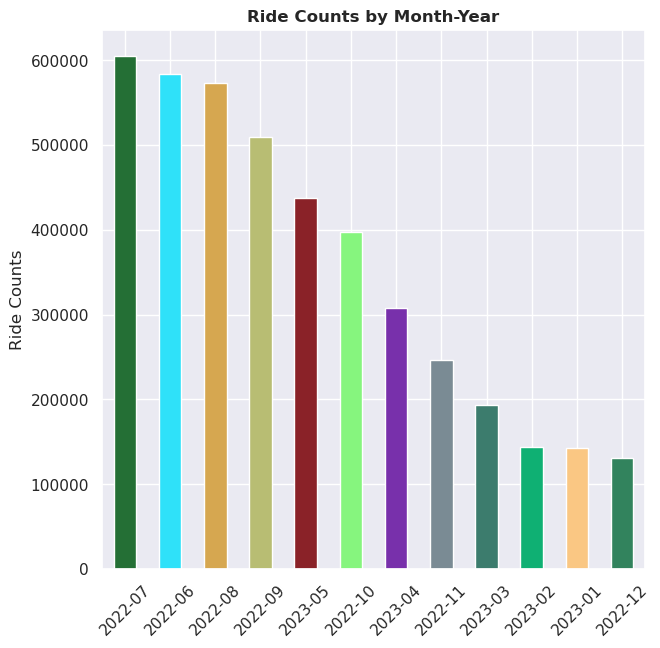

In [16]:
plt.figure(figsize=(7, 7))
ax = df['month_year'].value_counts().plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride Counts by Month-Year', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Counts')

Most rides are in summer months, i.e. July, August, and June. Least rides are in winter months, i.e.February, January, and December.

Text(0, 0.5, 'Ride Counts')

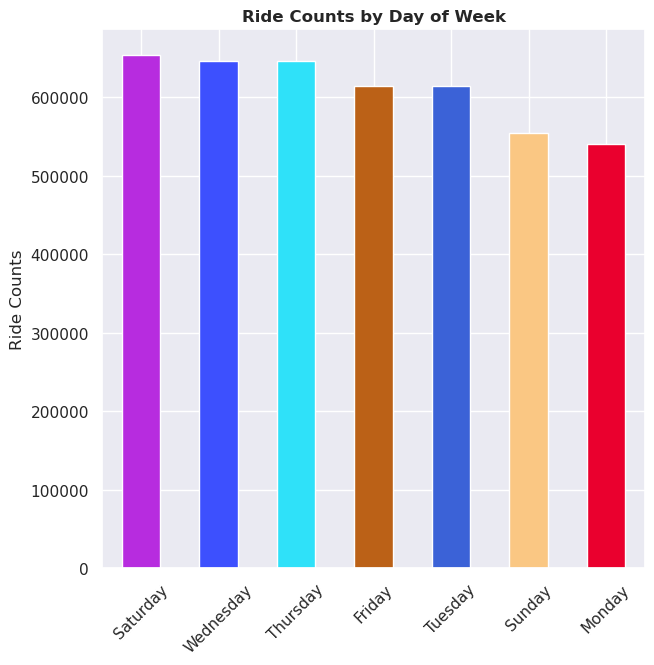

In [17]:
plt.figure(figsize=(7, 7))
ax = df['day_name'].value_counts().plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride Counts by Day of Week', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Counts')

Saturday has slightly more number of rides than on other days, and Monday has slightly less.

Text(0, 0.5, 'Ride Counts')

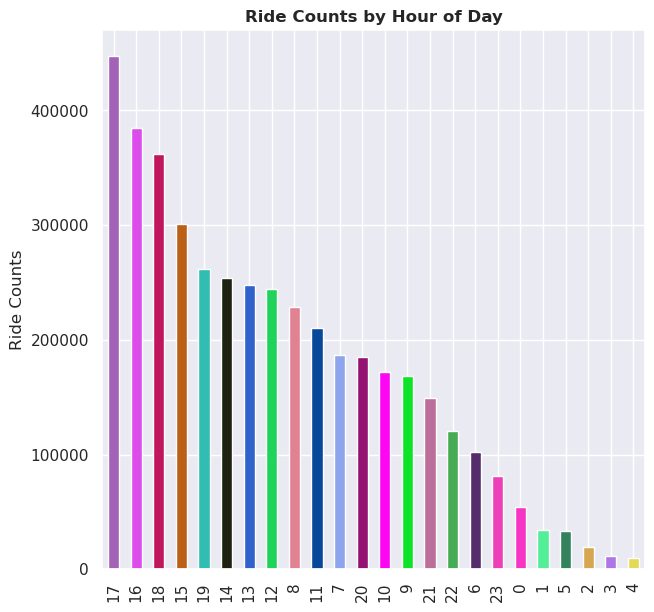

In [18]:
plt.figure(figsize=(7, 7))
ax = df['hour'].value_counts().plot.bar(color=random.sample(my_colors, 24))
plt.title('Ride Counts by Hour of Day', fontweight='bold', fontsize=12)
ax.set_ylabel('Ride Counts')

Rides taken during office-returning hours (4-6PM) are significantly more than those taken during office-going hours (8-10 AM).

Text(0, 0.5, 'Ride Counts')

<Figure size 700x700 with 0 Axes>

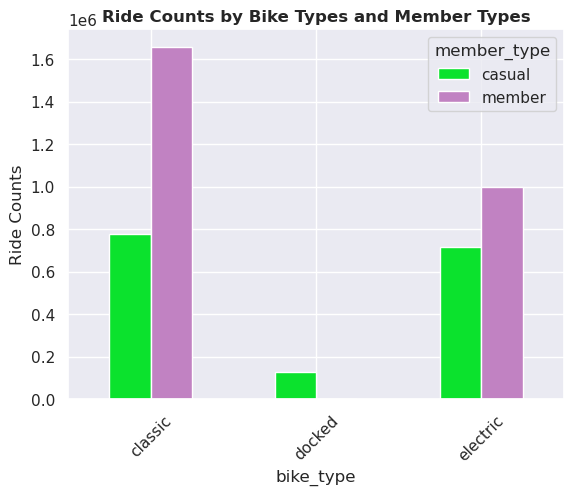

In [19]:
bike_member_count = df.pivot_table(index='bike_type', columns='member_type', values='ride_id', aggfunc='count')

plt.figure(figsize=(7, 7))
ax = bike_member_count.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride Counts by Bike Types and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Counts')

Docked bikes are used only by non-members. Even among non-members, a small fraction uses them. Members are more likely to use classic bikes over electric. But non-members are equally likely to use electric and classic bikes. Among classic bike users, the difference in proportions of members and non-members is higher (with members riding roughly twice as many times as non-members) than among electric bike users. 

Text(0, 0.5, 'Ride Counts')

<Figure size 700x700 with 0 Axes>

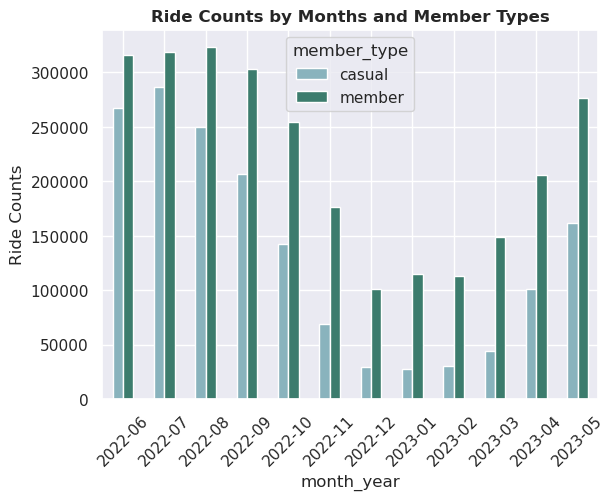

In [20]:
month_member_count = df.pivot_table(index='month_year', columns='member_type', values='ride_id', aggfunc='count')

plt.figure(figsize=(7, 7))
ax = month_member_count.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride Counts by Months and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Counts')

Bikes are used significantly more by members across all months. In summer months, a lot of non-members suddenly start using the bikes and their proportion becomes almost comparable to that of the members. In winter months, usage by non-members decreases significantly and a high fraction of bike-users are members. Even so, the bike usage by members itself drops significantly during winter months.

Text(0, 0.5, 'Ride Counts')

<Figure size 700x700 with 0 Axes>

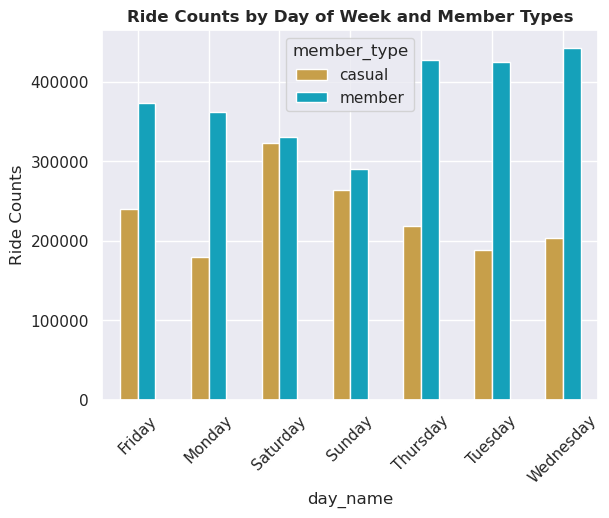

In [21]:
day_member_count = df.pivot_table(index='day_name', columns='member_type', values='ride_id', aggfunc='count')

plt.figure(figsize=(7, 7))
ax = day_member_count.plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride Counts by Day of Week and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Counts')

On all weekdays, bikes are used significantly more by members. But during weekends, a lot of non-members also use the bike, there numbers become almost comparable to those of members. Bike usage by members drops significantly during weekends.

Text(0, 0.5, 'Ride Counts')

<Figure size 700x700 with 0 Axes>

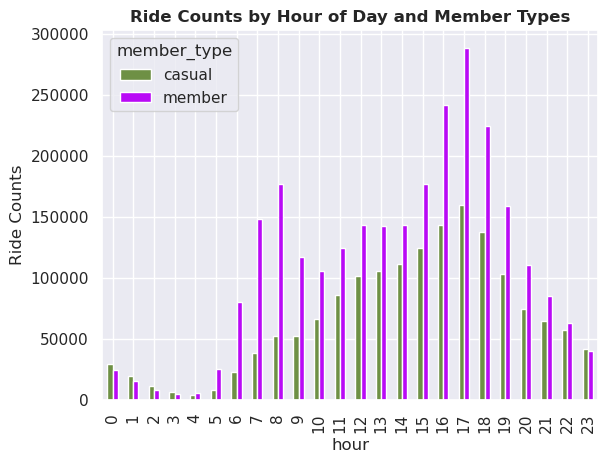

In [22]:
hour_member_count = df.pivot_table(index='hour', columns='member_type', values='ride_id', aggfunc='count')

plt.figure(figsize=(7, 7))
ax = hour_member_count.plot.bar(color=random.sample(my_colors, 24))
plt.title('Ride Counts by Hour of Day and Member Types', fontweight='bold', fontsize=12)
ax.set_ylabel('Ride Counts')

At most times during day, the proportion of members riding bike is significantly higher than the non-members. But during odd hours of day (11 PM - 3 AM), non-members are at times found as majority users, and their numbers become almost comparable to those of members.


The last 4 points indicate,

Bike usage by non-members increases significantly during late night, weekends, and summer months. Members, in contrast, tend to use the bikes more during day hours, weekdays, and in summer months. In winter months, the bike usage is quite low, in general.

Text(0, 0.5, 'Ride Counts')

<Figure size 700x700 with 0 Axes>

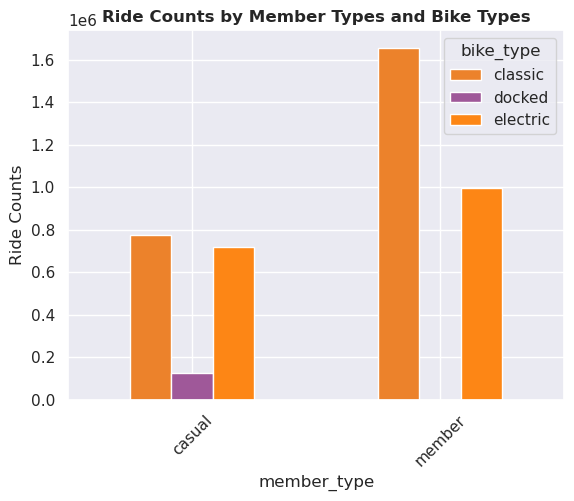

In [23]:
member_bike_count = df.pivot_table(index='member_type', columns='bike_type', values='ride_id', aggfunc='count')

plt.figure(figsize=(7, 7))
ax = member_bike_count.plot.bar(color=random.sample(my_colors, 3))
plt.title('Ride Counts by Member Types and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Counts')

Text(0, 0.5, 'Ride Counts')

<Figure size 700x700 with 0 Axes>

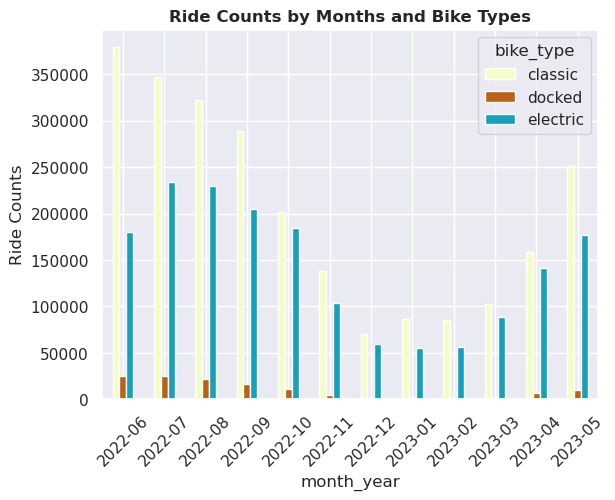

In [24]:
month_bike_count = df.pivot_table(index='month_year', columns='bike_type', values='ride_id', aggfunc='count')

plt.figure(figsize=(7, 7))
ax = month_bike_count.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride Counts by Months and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Counts')

Docked bikes, used by non-members alone, are more frequently used in summers. These are hardly used in winters at all. Classic bikes are used more frequently across all months. The difference between usages of classic and electric bikes is higher during summers, and it winters, these tend to be comparable.

Text(0, 0.5, 'Ride Counts')

<Figure size 700x700 with 0 Axes>

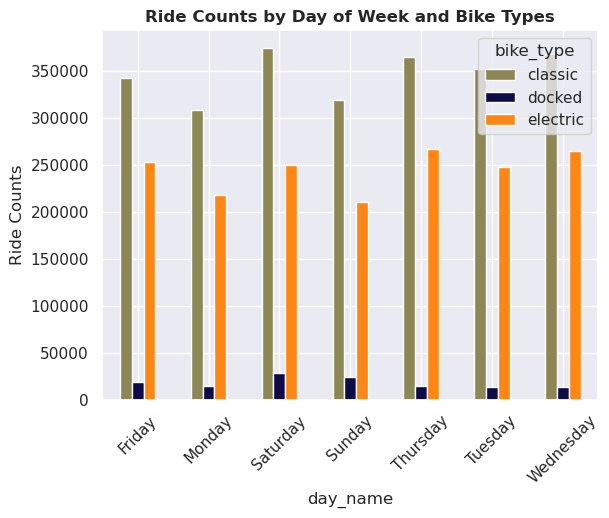

In [25]:
day_bike_count = df.pivot_table(index='day_name', columns='bike_type', values='ride_id', aggfunc='count')

plt.figure(figsize=(7, 7))
ax = day_bike_count.plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride Counts by Day of Week and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Counts')

Classic bikes are used more than electric on all days. However, the usage of docked bikes by non-members increases during the weekends. The bike usage on Saturdays is the highest and that on Sundays is somewhat less than expected, probably because of it being a rest-day.

Text(0, 0.5, 'Ride Counts')

<Figure size 700x700 with 0 Axes>

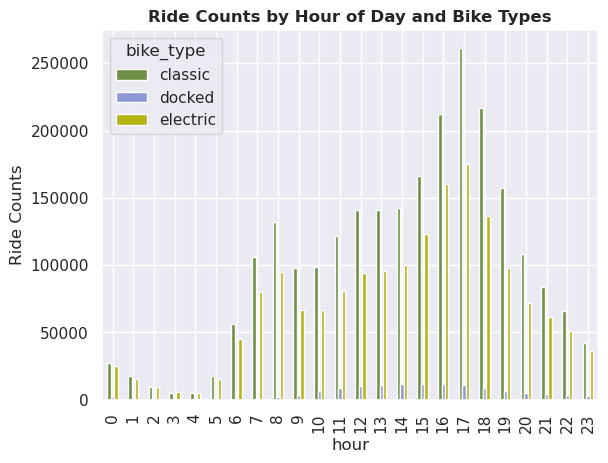

In [26]:
hour_bike_count = df.pivot_table(index='hour', columns='bike_type', values='ride_id', aggfunc='count')

plt.figure(figsize=(7, 7))
ax = hour_bike_count.plot.bar(color=random.sample(my_colors, 24))
plt.title('Ride Counts by Hour of Day and Bike Types', fontweight='bold', fontsize=12)
ax.set_ylabel('Ride Counts')

Classic bikes are used more than electric at all hours of a day. During day hours, usage of classic bikes is significantly more than electric, but their usages become comparable in the late night hours (12 midnight-4 AM). The usage of docked bike by non-members increases during 2-6 PM.

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

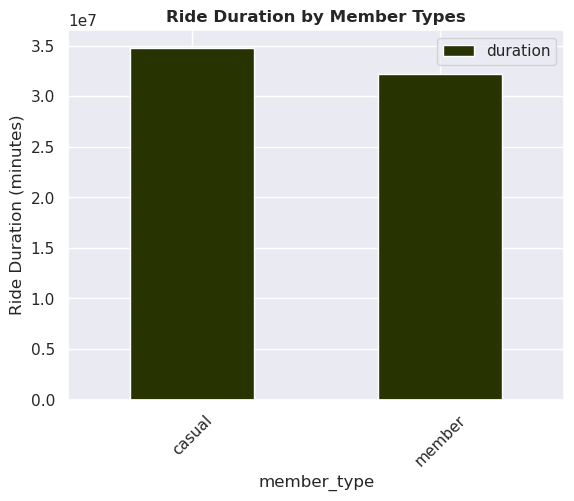

In [27]:
member_duration = df.pivot_table(index='member_type', values='duration', aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = member_duration.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride Duration by Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

Bikes are used for slightly more hours by non-members.

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

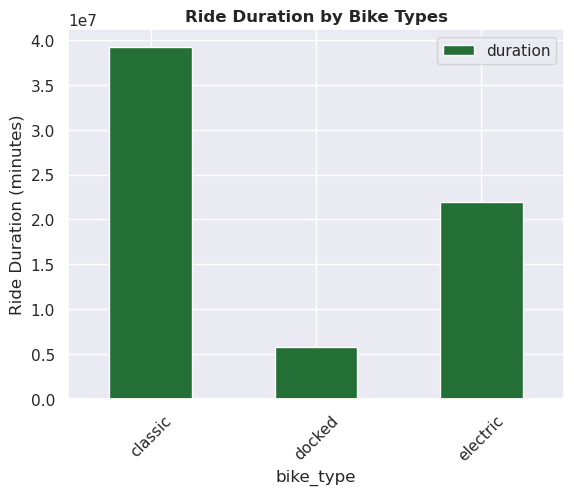

In [28]:
bike_duration = df.pivot_table(index='bike_type', values='duration', aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = bike_duration.plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride Duration by Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

Classic bikes are used for significantly more hours than electric bikes. Docked bikes, used by non-members alone, also see a non-negligible riding duration.

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

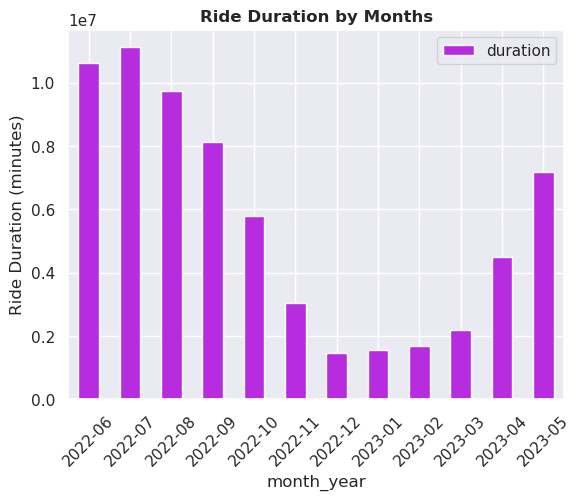

In [29]:
month_duration = df.pivot_table(index='month_year', values='duration', aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = month_duration.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride Duration by Months', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

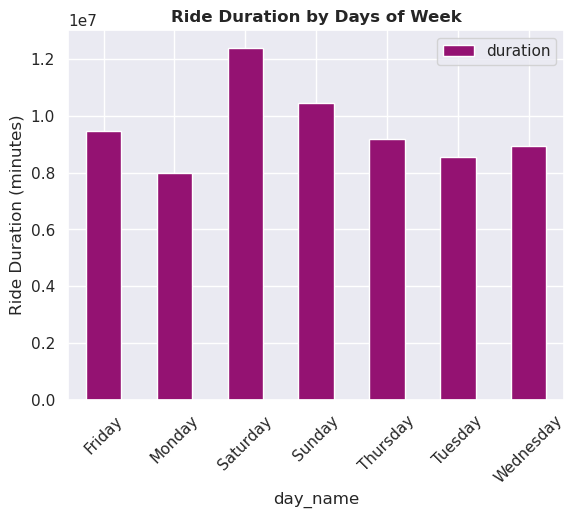

In [30]:
day_duration = df.pivot_table(index='day_name', values='duration', aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = day_duration.plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride Duration by Days of Week', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

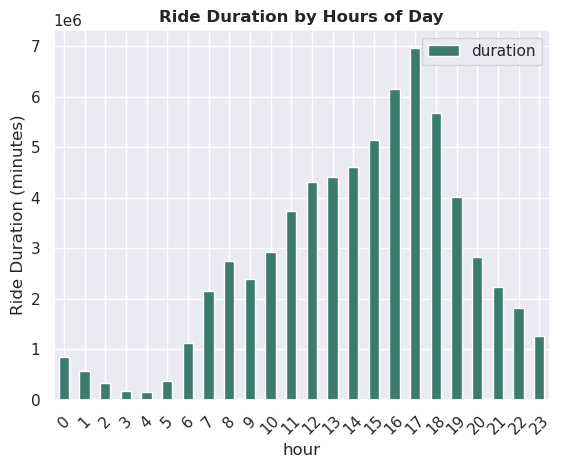

In [31]:
hour_duration = df.pivot_table(index='hour', values='duration', aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = hour_duration.plot.bar(color=random.sample(my_colors, 24))
plt.title('Ride Duration by Hours of Day', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)') 

The ride durations are significantly higher in summer months, weekends, and during the office-returning hours (4-6 PM).

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

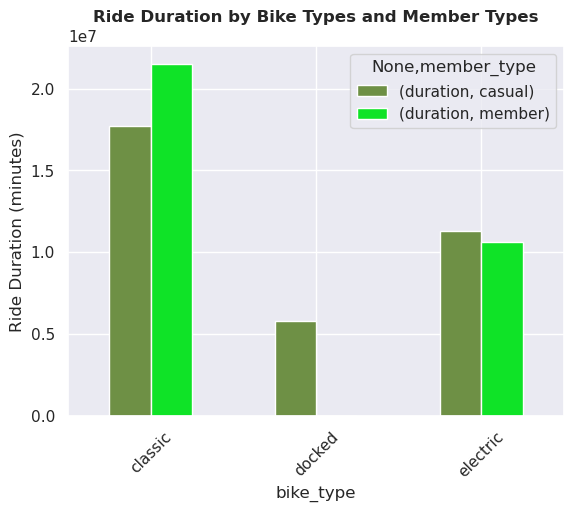

In [32]:
bike_member_duration = df.pivot_table(index=['bike_type'], columns=['member_type'], values=['duration'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = bike_member_duration.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride Duration by Bike Types and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

Among classic bike users, members constitute a higher fraction. Among electric bike users, non-members constitute a higher fraction. Ride durations on docked bikes by non-members is non-negligible.

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

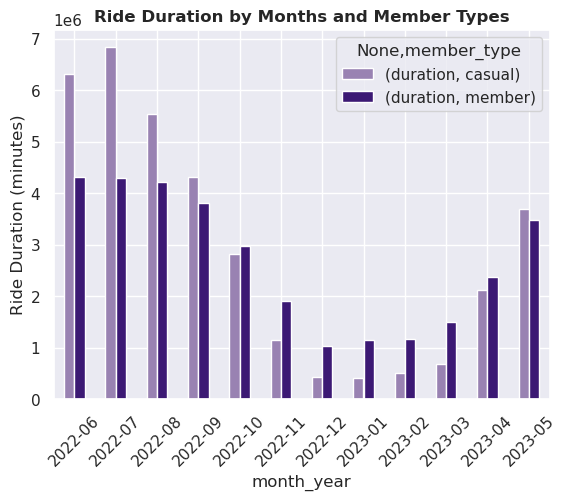

In [33]:
month_member_duration = df.pivot_table(index=['month_year'], columns=['member_type'], values=['duration'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = month_member_duration.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride Duration by Months and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

In summer months, non-members use the bike for longer hours, while in winter months, members use the bike for longer hours. In mid-months April and May, ride durations by members and non-members is comparable. Ride durations of non-members fluctuates more across months.

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

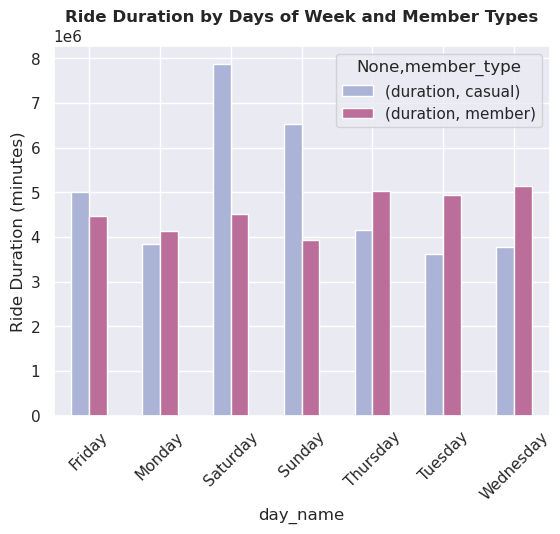

In [34]:
day_member_duration = df.pivot_table(index=['day_name'], columns=['member_type'], values=['duration'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = day_member_duration.plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride Duration by Days of Week and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

Ride durations by non-members from Friday-Sunday is significantly higher than those by members. However, on weekdays, the ride duration by members stays clearly higher.


Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

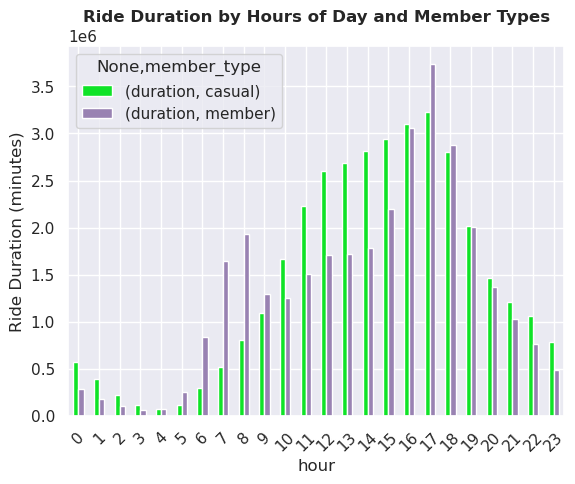

In [35]:
hour_member_duration = df.pivot_table(index=['hour'], columns=['member_type'], values=['duration'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = hour_member_duration.plot.bar(color=random.sample(my_colors, 24))
plt.title('Ride Duration by Hours of Day and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

Ride durations by non-members is higher between 10 AM - 3 PM. Members ride for significantly more time during 5-9 AM (office going hours) and 5-6 PM. At all other times, their ride durations are comparable.

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

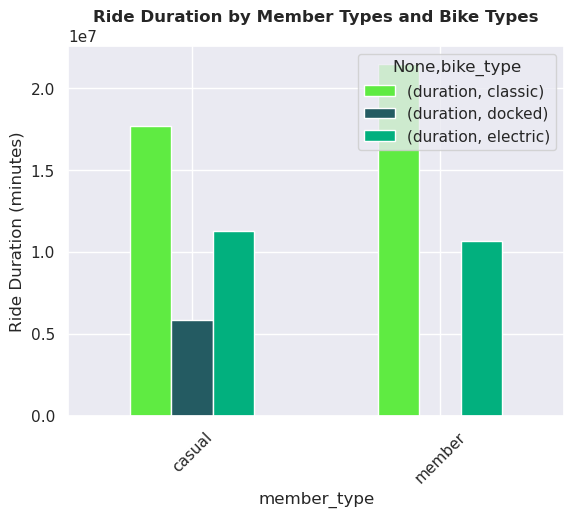

In [36]:
member_bike_duration = df.pivot_table(index=['member_type'], columns=['bike_type'], values=['duration'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = member_bike_duration.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride Duration by Member Types and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

Most ride hours are spent by members on classic bikes. The ride duration by members on classic bikes is significantly more than on electric bikes. Both members and non-members spend more riding time on classic bikes.

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

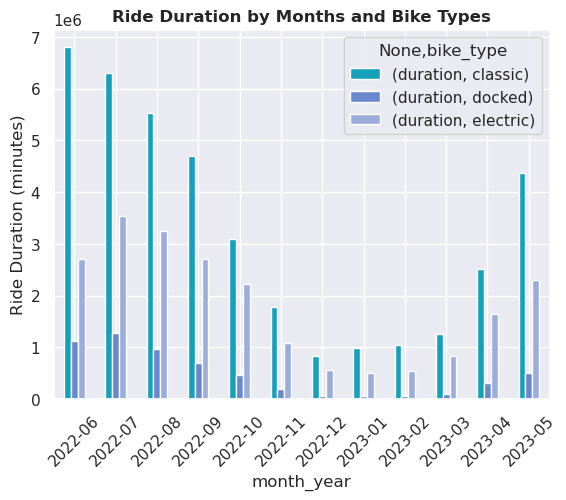

In [37]:
month_bike_duration = df.pivot_table(index=['month_year'], columns=['bike_type'], values=['duration'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = month_bike_duration.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride Duration by Months and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

Across all months, specially summer months, classic bikes are rid for significantly longer hours than electric bikes. In winter months, the difference in their ride durations somewhat closes.

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

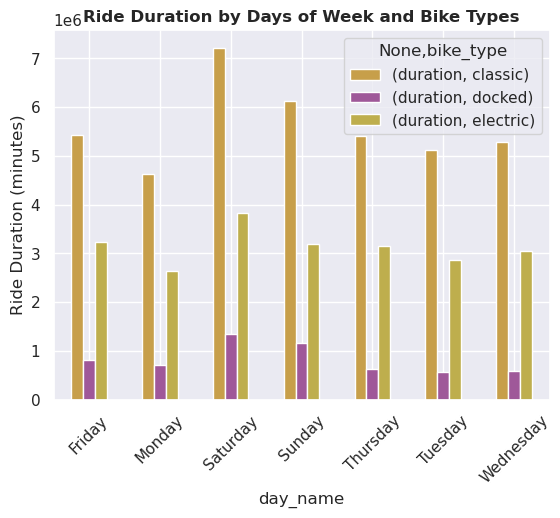

In [38]:
day_bike_duration = df.pivot_table(index=['day_name'], columns=['bike_type'], values=['duration'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = day_bike_duration.plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride Duration by Days of Week and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

On all days, classic bikes are used for significantly and consistently more hours than electric ones. Docked bikes are used for longer hours during weekends.

Text(0, 0.5, 'Ride Duration (minutes)')

<Figure size 700x700 with 0 Axes>

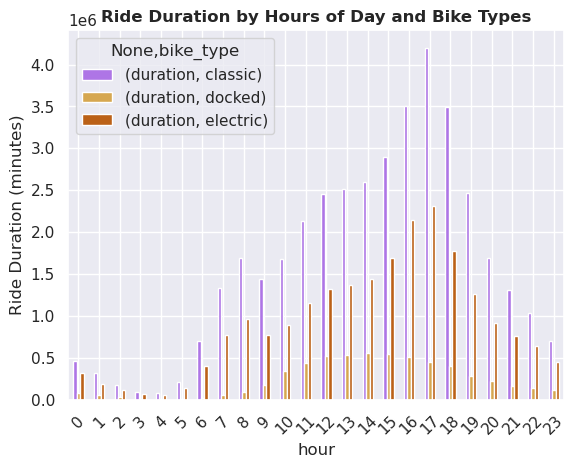

In [39]:
hour_bike_duration = df.pivot_table(index=['hour'], columns=['bike_type'], values=['duration'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = hour_bike_duration.plot.bar(color=random.sample(my_colors, 24))
plt.title('Ride Duration by Hours of Day and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride Duration (minutes)')

At all hours during day, classic bikes are used for a longer duration. The difference in ride durations between classic and electric bikes is wider during day hours and less so during late night hours.

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

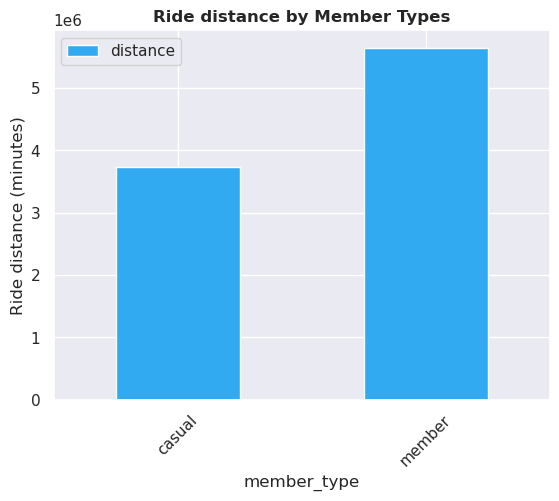

In [40]:
member_distance = df.pivot_table(index='member_type', values='distance', aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = member_distance.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride distance by Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

Members ride for significantly longer distances than non-members. 

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

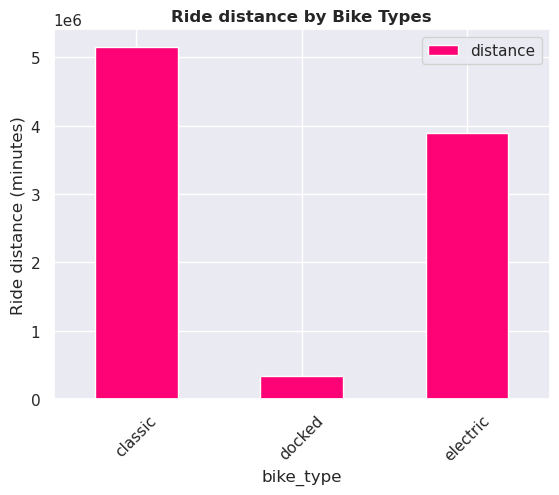

In [41]:
bike_distance = df.pivot_table(index='bike_type', values='distance', aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = bike_distance.plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride distance by Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

Classic bikes are used over longer distances than electric.

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

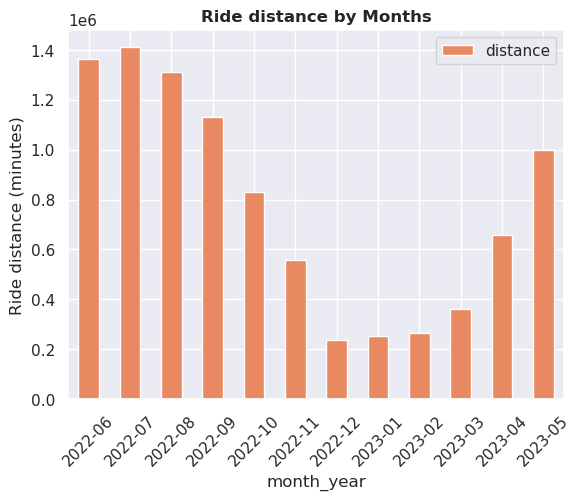

In [42]:
month_distance = df.pivot_table(index='month_year', values='distance', aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = month_distance.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride distance by Months', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

Ride distances are longest during summer months and lowest during winter months. 

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

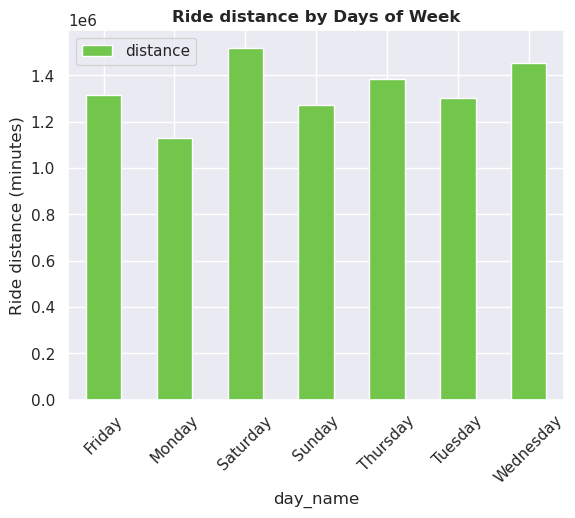

In [43]:
day_distance = df.pivot_table(index='day_name', values='distance', aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = day_distance.plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride distance by Days of Week', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

Ride distances are longest during Saturdays. Surprisingly, ride distances are higher on Wednesdays than on Fridays or Sundays.

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

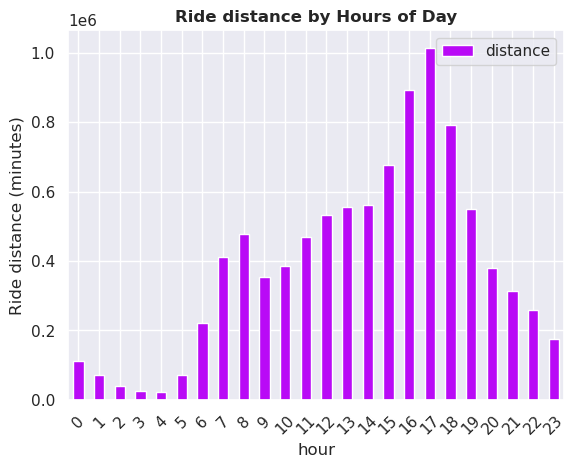

In [44]:
hour_distance = df.pivot_table(index='hour', values='distance', aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = hour_distance.plot.bar(color=random.sample(my_colors, 24))
plt.title('Ride distance by Hours of Day', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')   

Ride distances are longest during 4-6 PM and lowest during early morning hours (2-4 AM). These increase slightly during 7-9 AM (office going hours), go down a bit during 9-10 AM. And again increase steadily during day, peaking at office returning hours.

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

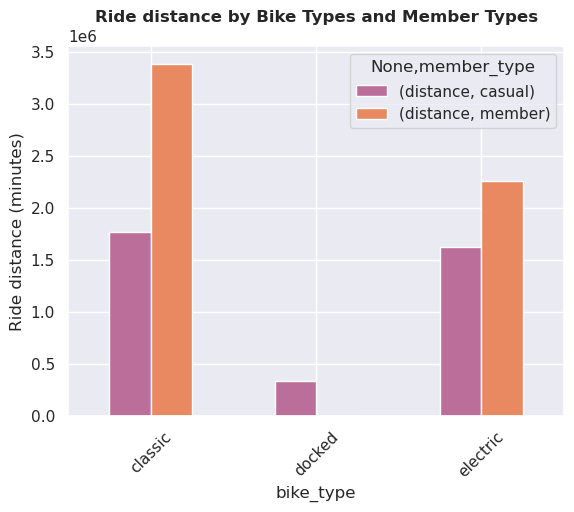

In [45]:
bike_member_distance = df.pivot_table(index=['bike_type'], columns=['member_type'], values=['distance'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = bike_member_distance.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride distance by Bike Types and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

Members ride the bike for longer distances than non-members with both classic and electric bikes. Among members, ride distances on classic bikes are significantly higher than on electric. For non-members, the ride distances on classic and electric bikes are comparable.

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

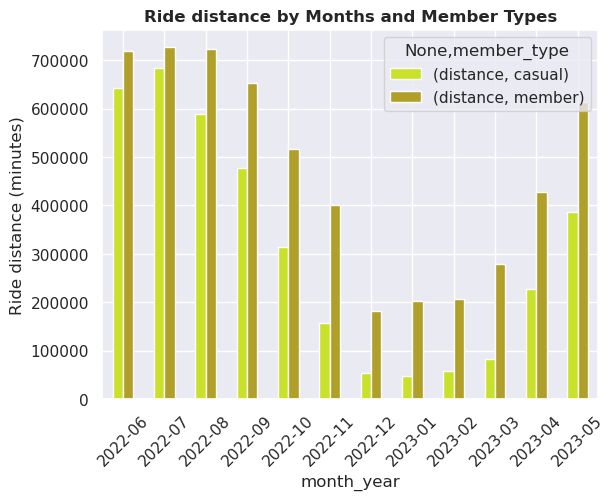

In [46]:
month_member_distance = df.pivot_table(index=['month_year'], columns=['member_type'], values=['distance'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = month_member_distance.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride distance by Months and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

Members ride for longer distances than non-members across all months. The difference between their ride distances is higher during winter months. In summer months, non-members also ride for significant distances, and this gap tends to close.

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

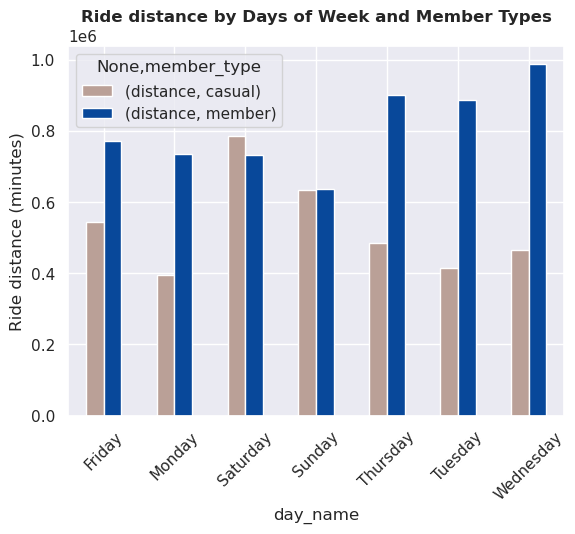

In [47]:
day_member_distance = df.pivot_table(index=['day_name'], columns=['member_type'], values=['distance'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = day_member_distance.plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride distance by Days of Week and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

On all weekdays, members ride significantly more distances than non-members (almost around twice as much). However, on Sundays, they ride comparable distances and on Saturdays, non-members overtake members in riding longer distances.


Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

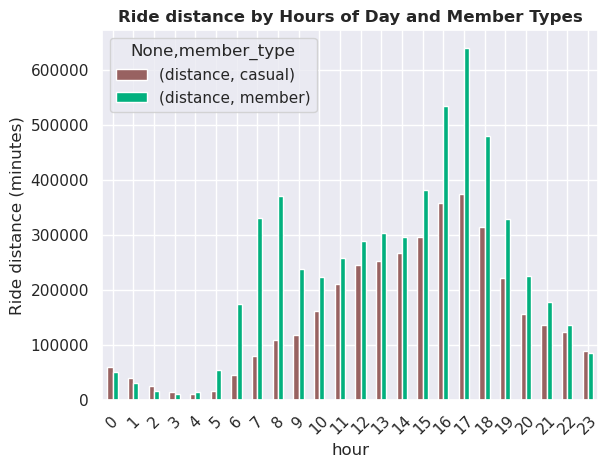

In [48]:
hour_member_distance = df.pivot_table(index=['hour'], columns=['member_type'], values=['distance'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = hour_member_distance.plot.bar(color=random.sample(my_colors, 24))
plt.title('Ride distance by Hours of Day and Member Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

Members ride longer distances than non-members during the day hours (4 AM- 10 PM). The difference is sharp during office going (7-9 AM) and returning hours (4-6 PM). During late night, this gap tends to close. And during midnight to early morning (12 midnight - 3 AM), non-members tend to ride longer distances.

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

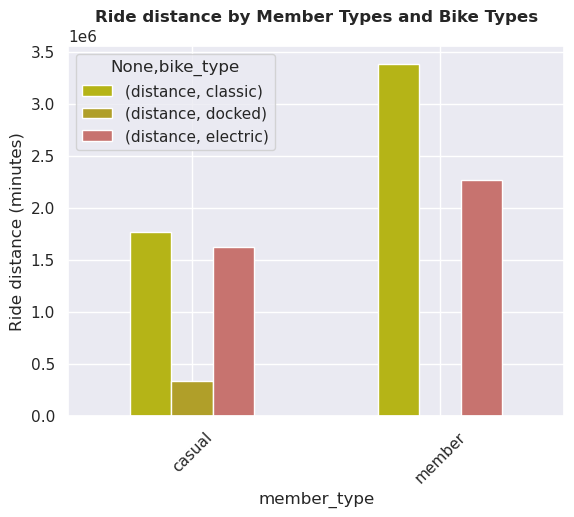

In [49]:
member_bike_distance = df.pivot_table(index=['member_type'], columns=['bike_type'], values=['distance'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = member_bike_distance.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride distance by Member Types and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

The longest ride distances are seen with members riding classic bikes. Among members, the difference in ride distances between those riding electric and classic bikes is significantly higher, than non-members. Even, the ride distances by members on electric bikes is more than non-members on classic ones.

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

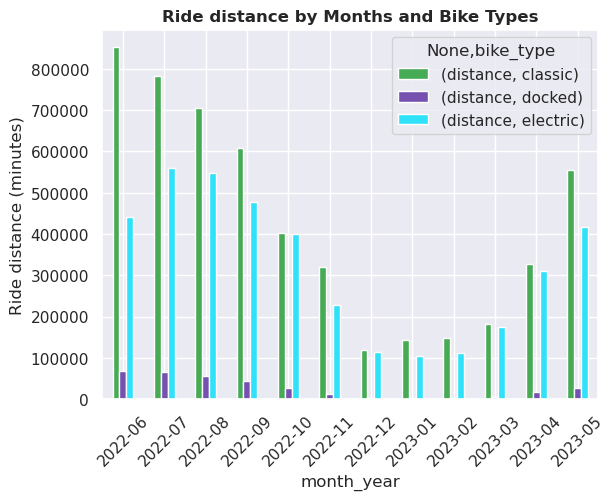

In [50]:
month_bike_distance = df.pivot_table(index=['month_year'], columns=['bike_type'], values=['distance'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = month_bike_distance.plot.bar(color=random.sample(my_colors, 12))
plt.title('Ride distance by Months and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

Amost across all months, specially during summer months, classic bikes are rid for significantly longer distances than electric bikes. In winter months (Dec-April), this gap tends to close.

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

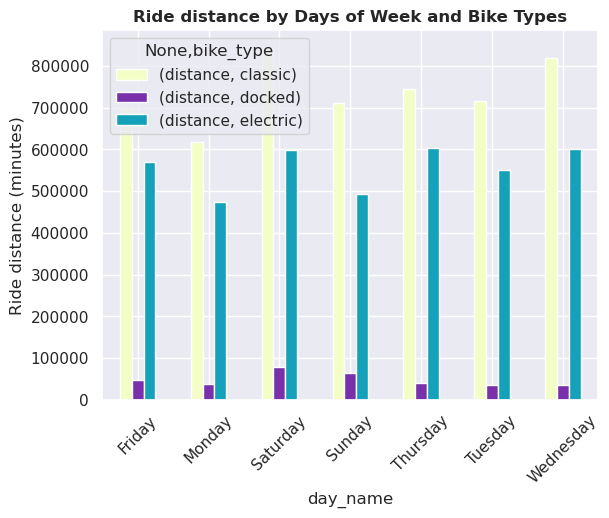

In [51]:
day_bike_distance = df.pivot_table(index=['day_name'], columns=['bike_type'], values=['distance'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = day_bike_distance.plot.bar(color=random.sample(my_colors, 7))
plt.title('Ride distance by Days of Week and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

On all days of week, classic bikes are used over longer distances than electric bikes. On Saturday, this gap is the widest. Probably, many non-members are also using the classic bike during weekends, specially, Saturday.

Text(0, 0.5, 'Ride distance (minutes)')

<Figure size 700x700 with 0 Axes>

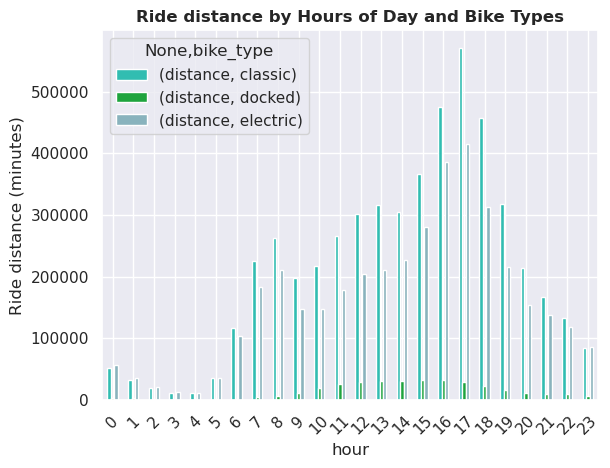

In [52]:
hour_bike_distance = df.pivot_table(index=['hour'], columns=['bike_type'], values=['distance'], aggfunc='sum')

plt.figure(figsize=(7, 7))
ax = hour_bike_distance.plot.bar(color=random.sample(my_colors, 24))
plt.title('Ride distance by Hours of Day and Bike Types', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Ride distance (minutes)')

During most of the day hours (6 AM-10 PM), classic bikes are used for longer distances. However, during late night and early morning hours (11 PM-5 AM), electric bikes are used for comparable distances as classic bikes, sometimes, even more.

Text(0.5, 1.0, 'Variation in Ride Durations by Member Types')

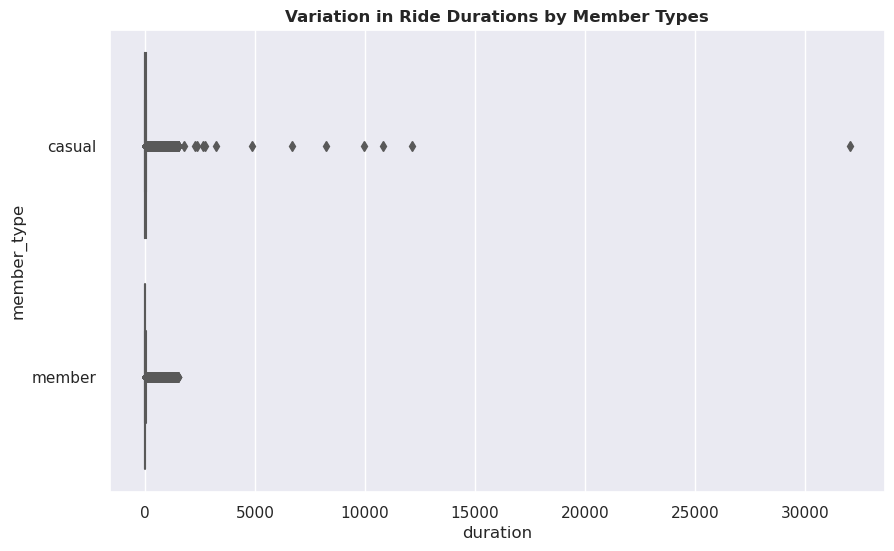

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='duration', y='member_type')
plt.title('Variation in Ride Durations by Member Types', fontweight='bold', fontsize=12)

Non-members have some high outliers in ride-durations with docked bikes, which tend to skew the total duration. 

Text(0.5, 1.0, 'Variation in Ride Durations by Bike Types')

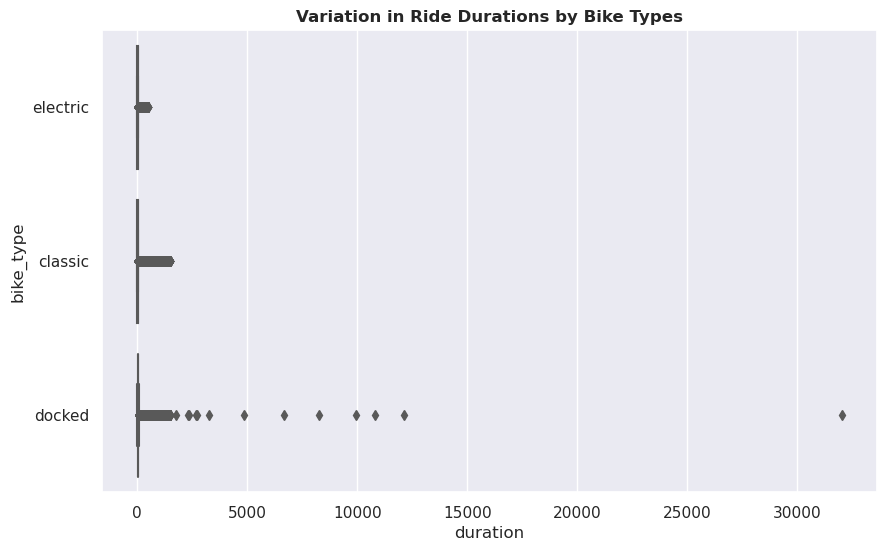

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='duration', y='bike_type')
plt.title('Variation in Ride Durations by Bike Types', fontweight='bold', fontsize=12)

Text(0.5, 1.0, 'Month-wise Variation in Ride Durations by Member Types')

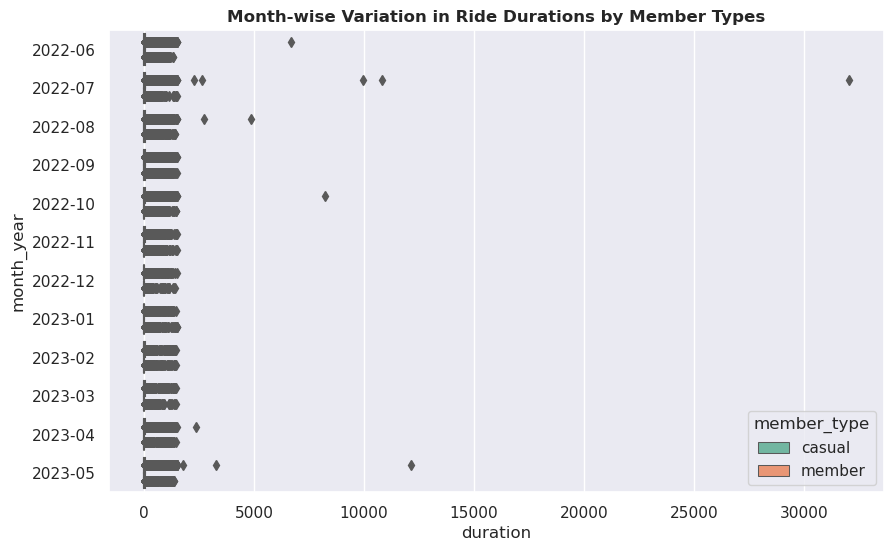

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='duration', y='month_year', hue='member_type')
plt.title('Month-wise Variation in Ride Durations by Member Types', fontweight='bold', fontsize=12)   

The outliers in ride durations are observed more in the summer months, and hardly at all in winter months.

Text(0.5, 1.0, 'Day-wise Variation in Ride Durations by Member Types')

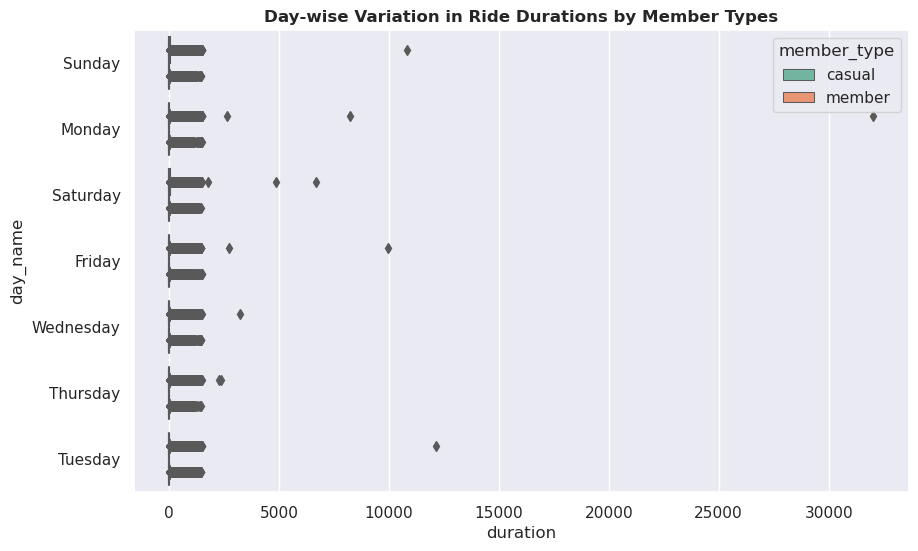

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='duration', y='day_name', hue='member_type')
plt.title('Day-wise Variation in Ride Durations by Member Types', fontweight='bold', fontsize=12)    

While outliers in ride durations are seen more during Friday-Sunday, the highest outlier falls surprisingly on Monday.

Text(0.5, 1.0, 'Variation in Ride Distances by Member Types')

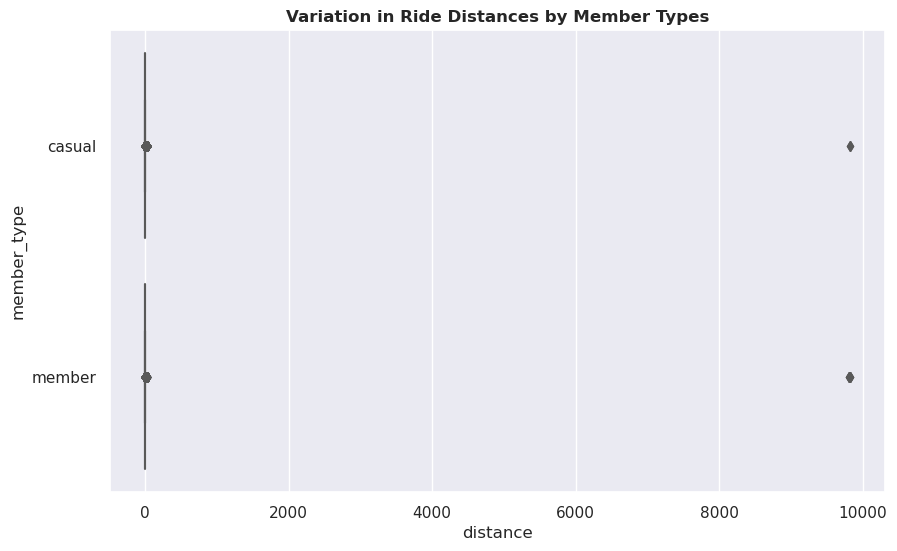

In [57]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='distance', y='member_type')
plt.title('Variation in Ride Distances by Member Types', fontweight='bold', fontsize=12)

Both a member and a non-member have a high outlier in ride distances, used with classic and electric bikes respectively. Surprisingly, these outliers come in the month of November, on a Wednesday, which see otherwise low relative usage. Removing these outliers will increase the contrast in usages across summer and winter months.

Text(0.5, 1.0, 'Variation in Ride Distances by Bike Types')

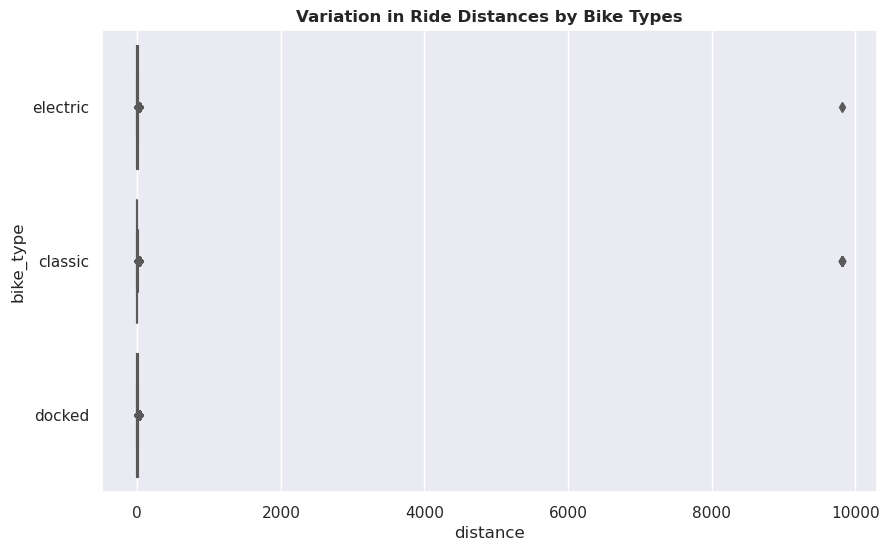

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='distance', y='bike_type')
plt.title('Variation in Ride Distances by Bike Types', fontweight='bold', fontsize=12)

Text(0.5, 1.0, 'Month-wise Variation in Ride Distances by Member Types')

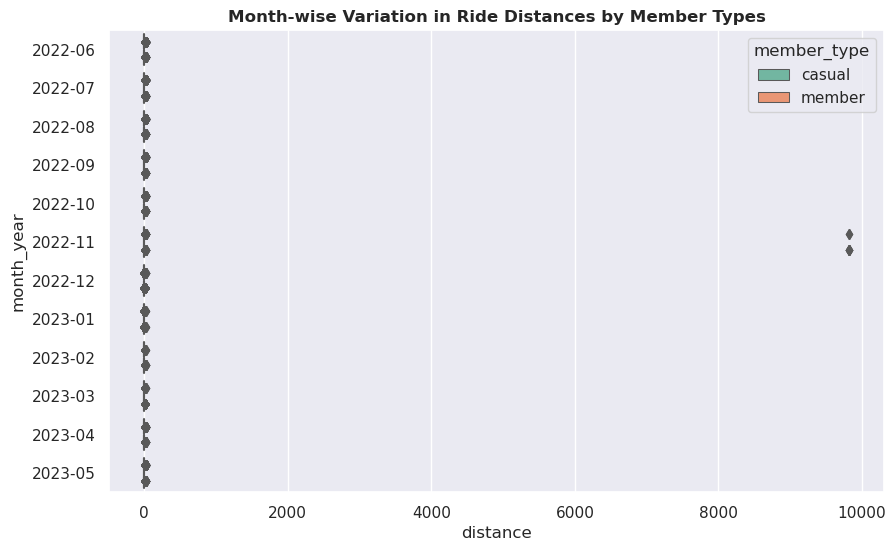

In [59]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='distance', y='month_year', hue='member_type')
plt.title('Month-wise Variation in Ride Distances by Member Types', fontweight='bold', fontsize=12)

Text(0.5, 1.0, 'Day-wise Variation in Ride Distances by Member Types')

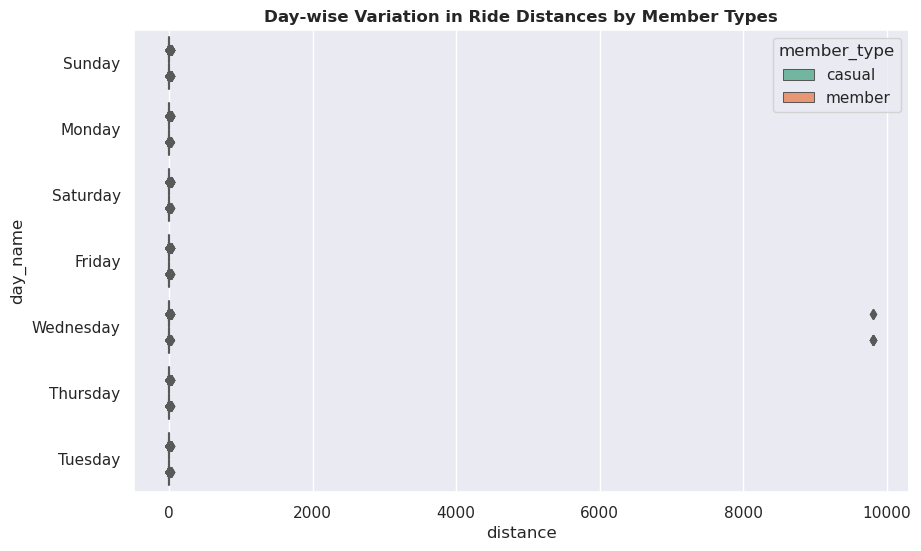

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='distance', y='day_name', hue='member_type')
plt.title('Day-wise Variation in Ride Distances by Member Types', fontweight='bold', fontsize=12)

Both a member and a non-member have a high outlier in ride distances, used with classic and electric bikes respectively. Surprisingly, these outliers come in the month of November, on a Wednesday, which see otherwise low relative usage. Removing these outliers will increase the contrast in usages across summer and winter months.

In [61]:
df['route'].nunique(), df['route'].duplicated().sum()

(171483, 4099833)

In [62]:
route_freq = df['route'].value_counts()
route_freq.head(20)

KA1503000014-KA1503000071    7497
KA1503000014-KA1504000076    7172
KA1503000071-KA1503000014    7038
KA1504000076-KA1503000014    6737
13300-13022                  5620
13216-13217                  4347
13217-13216                  4196
13332-TA1307000130           3883
KA1503000071-TA1309000037    3656
TA1307000130-13332           3652
TA1309000037-KA1503000071    3256
13022-13300                  3238
13022-13008                  2846
13022-LF-005                 2828
13022-13042                  2746
13022-13022                  2669
15544-13022                  2498
KA1504000076-TA1309000037    2473
13008-13022                  2440
KA1503000071-TA1309000063    2410
Name: route, dtype: int64

In [63]:
route_freq[route_freq==1]

15655-13253           1
TA1305000029-15442    1
13017-TA1308000013    1
TA1307000117-15446    1
13294-KA1503000044    1
                     ..
464-596               1
13307-TA1309000024    1
398-TA1309000024      1
13300-596             1
965-13084             1
Name: route, Length: 44584, dtype: int64

In [64]:
route_freq[route_freq > 5000]

KA1503000014-KA1503000071    7497
KA1503000014-KA1504000076    7172
KA1503000071-KA1503000014    7038
KA1504000076-KA1503000014    6737
13300-13022                  5620
Name: route, dtype: int64

In [66]:
route_member_count = df.pivot_table(index='route', columns='member_type', values='ride_id', aggfunc='count').sort_values(['casual', 'member'], ascending=[False, False])
route_member_count['total'] = route_member_count['casual'] + route_member_count['member']
route_member_count.sort_values(['total', 'member', 'casual'], ascending=[False, False, False], inplace=True)

top_routes = route_member_count.head(100)

distances, durations = [], []

for route in top_routes.index:
    
    distances.append(df[df['route']==route]['distance'].values[0])
    durations.append(df[df['route']==route]['duration'].mean())
    
top_routes['distance'] = distances
top_routes['duration'] = durations
top_routes['ratio'] = round(top_routes['member']/top_routes['casual'], 2)

top_routes.head()

member_type,casual,member,total,distance,duration,ratio
route,,,,,,
KA1503000014-KA1503000071,1252.0,6245.0,7497.0,0.72,4.594994,4.99
KA1503000014-KA1504000076,1453.0,5719.0,7172.0,1.02,5.282315,3.94
KA1503000071-KA1503000014,1144.0,5894.0,7038.0,0.72,5.000301,5.15
KA1504000076-KA1503000014,1343.0,5394.0,6737.0,1.02,5.409651,4.02
13300-13022,5101.0,519.0,5620.0,1.32,26.450460,0.10


In [67]:
top_routes[top_routes['ratio'] > 1]['distance'].mean(), top_routes[top_routes['ratio'] > 1]['duration'].mean(), top_routes[top_routes['ratio'] < 1]['distance'].mean(), top_routes[top_routes['ratio'] < 1]['duration'].mean()

(0.8943283582089553, 6.485966191943128, 1.6018181818181818, 27.16784191968975)

There are 0.17 million unique routes covering around 4.27 million trips. Of these, 4.09 million trips are on repeated routes. Around 45,000 routes are used only once. Around 10,000 routes are used more than 100 times. Around 110 routes are used more than 1000 times. Only 5 routes are used more than 5000 times.

67% of the top 100 most frequented routes are used pre-dominantly by members. Among these routes where members are more than non-members, the average distance is only approx 0.9 km and average duration is only approx 6.5 minutes. In contrast, the routes which have more non-members than members, have average distance as approx 1.6 km and average duration as approx 27 min. This suggests that members are using non-members are often travelling for longer distances and times among the top 100 most frequented routes.

Text(0.5, 1.0, 'Ratio of Members to Casual Riders vs Average Route Duration (min))')

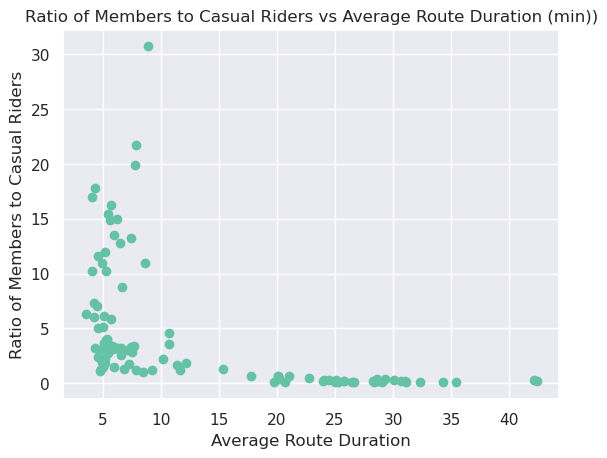

In [68]:
plt.scatter(top_routes['duration'], top_routes['ratio'])
plt.xlabel('Average Route Duration')
plt.ylabel('Ratio of Members to Casual Riders')
plt.title('Ratio of Members to Casual Riders vs Average Route Duration (min))')

Text(0.5, 1.0, 'Ratio of Members to Casual Riders vs Route Length (kms)')

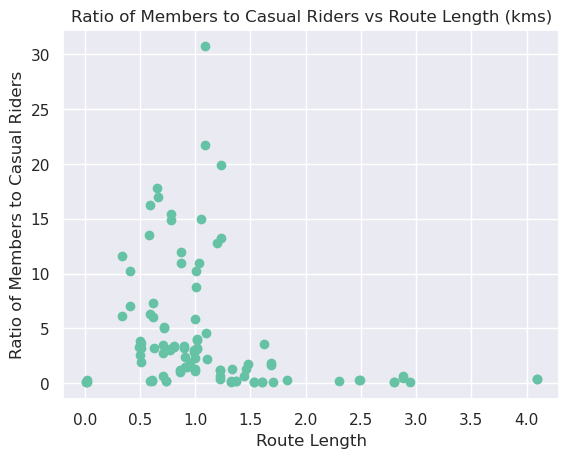

In [69]:
plt.scatter(top_routes['distance'], top_routes['ratio'])
plt.xlabel('Route Length')
plt.ylabel('Ratio of Members to Casual Riders')
plt.title('Ratio of Members to Casual Riders vs Route Length (kms)')

The routes with higher member:non-member ratio are typically between 0.5-1.5 kms long, and take around 5 to 10 minutes to cover. Longer and more time-taking routes often have more non-members than members (low member:non-member ratio).

**Conclusions**

The contrast in usage patterns of members and non-members is interesting. Most rides, in terms of counts, distances, and durations, are by members, often on classic bikes, during office going and returning hours, during summer seasons. In contrast, non-members tend to use the bikes more on weekends, specially, Saturdays, during summers, and even at late hours of night. In winters, the overall bike usage is low. Classic bikes are surprisingly used more than electric ones. Docked bikes are used exclusively by non-members. Its also surprising that bike usage is more during office returning hours than during office going hours.

Members tend to be steady office-commuters, often using classic bikes, active during office returning and going hours, during weekdays, specially in summer months.

The fraction of electric bike users is more among non-members as compared to members. Docked bikes are also used exclusively by non-members. Non-members are comparably and sometimes active than members during summer months, specially during weekends, late nights, and mid-days. Their ride counts, durations, and distances, as a whole are marginally less than members.

While ride counts and distances are more for members, ride durations are more for non-members. This is also partly caused by some outlier values in ride durations of non-members.

Among the most frequented routes, those with more non-members have higher average ride lengths and durations.

The usage of all bikes is in general relatively low during winters, Mondays and weekdays, and during late night hours.

The ids for distinct users is missing in the dataset. This missing data could be used for a closer analysis of route patterns of non-members and to perhaps recommend route-based discounts which might help them become members.

**Recommendations**

The conclusions are,

1. What makes non-members is different is that they ride even at late night hours, specially on weekends (Saturday), Non-members' ride counts, distances and durations peak during summers, weekends specially Saturdays, are significantly more during late nights and mid-days.

2. To support non-members to transition to membership plan, the firm can create micro-plans customised to each non-member's route profile, frequency, distances and durations and reach out to them through digital media. The firm can provide special incentives for traveling on specific routes, on weekdays, and during winter months.

Non-members may want to buy annual membership,

1. If they realize that members with similar riding behavior(route, distance, duration, frequency) are getting a better value with membership plans.

2. If they are provided customised membership plans optimised for their route, frequency, and distance/duration.

3. If as members, they are given better deals during their active periods: summers, weekends, late nights, on electric/docked bikes.

4. If they are given special incentives to ride during weekdays, winters, day hours, etc.


The firm can use digital media to,

1. Share customised plans optimised to their preferred bike types, route, distance/duration, etc.

2. Share benefits of membership plan with detailed calculation, realistic to their usage.

If approved by executive team, the product teams can design new, customised plans and additional incentives on specific routes, hours during day, winter months, etc.

The marketing team could share these plans with customers through digital media with targeted ads.

To segment members and non-members more finely, analytics could attempt to get data on user-ids, passes availed, and attempt to address missing values of station names and ids.

Is there additional data you could use to expand on your findings?

Data quality needs to be improved considerably. 

1. Missing station names and ids should be addressed.
2. User-ids are essential to any finer analysis.
3. Data for passes availed could help understand users' motivation better.
4. Erroneous data collection could be minimised, e.g. missing/incorrect timestamps, rides with negative duration/distance, etc. A better data validation will help.

**Top 3 recommendations**

1. To support non-members to transition to membership plan, the firm can create micro-plans customised to each non-member's route profile, frequency, distances and durations and reach out to them through digital media. 

2. The firm can provide special incentives for traveling on specific routes, during nights and mornings, on weekdays, and during winter months.

3. The firm could probe the proportion of non-members who are working professionals and if they avail any other service for daily commute. One can attempt to meet the same need using customised plans.
